In [ ]:
conda install scipy matplotlib scikit-learn

In [ ]:
pip install mne --upgrade

In [2]:
import mne
import matplotlib
import matplotlib.pyplot as plt

In [6]:
path = r"nback1.vhdr"
marker = r"nback1.vmrk"

In [7]:
matplotlib.use('Qt5Agg')
# %matplotlib widget
%matplotlib qt
# %gui qt
# mne.viz.set_3d_backend("notebook")

In [8]:
fname= "channel_loc.csv"
TUB_montage = mne.channels.read_custom_montage(fname)

In [9]:
raw = mne.io.read_raw_brainvision(path, eog=('HEOG', 'VEOG'), preload=True)

Extracting parameters from D:\Github_Projects\VP001\nback1.vhdr...
Setting channel info structure...


<ipython-input-9-147357d1d9df>:1: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (1000.00 Hz) will be stored.
  raw = mne.io.read_raw_brainvision(path, eog=('HEOG', 'VEOG'), preload=True)


Reading 0 ... 701439  =      0.000 ...   701.439 secs...


In [10]:
raw.set_montage(TUB_montage)

<ipython-input-10-5897c02f5ea4>:1: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(TUB_montage)


<RawBrainVision | nback1.eeg, 30 x 701440 (701.4 s), ~160.6 MB, data loaded>

In [11]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, AFF5, AFz, F1, FC5, FC1, T7, C3, Cz, CP5, CP1, P7, P3, Pz, ...
 chs: 28 EEG, 2 EOG
 custom_ref_applied: False
 dig: 28 items (28 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2016-05-26 12:38:27 UTC
 nchan: 30
 projs: []
 sfreq: 1000.0 Hz
>

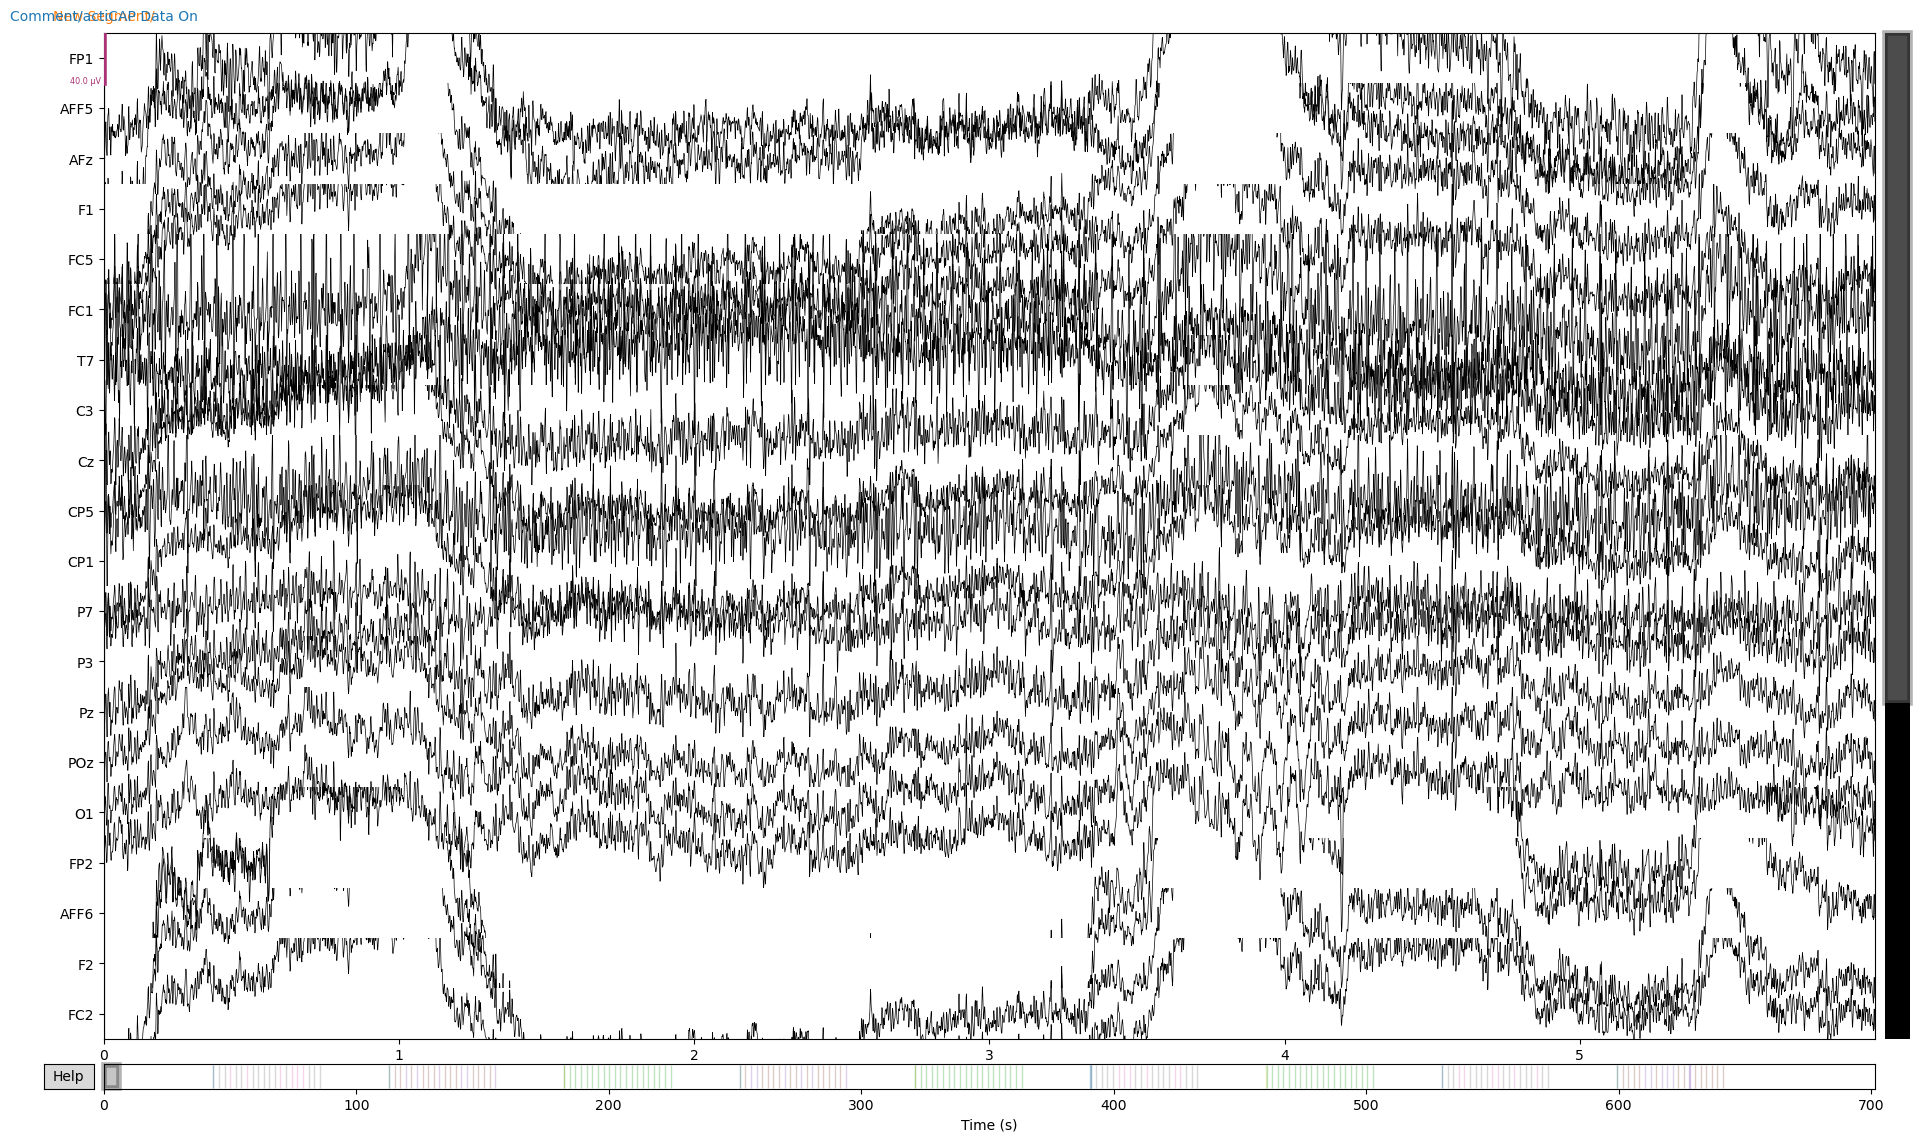

Channels marked as bad: none


In [34]:
raw.plot(start=0, duration=6)

In [13]:
mrk = mne.read_annotations(marker, sfreq='auto', uint16_codec=None)

Finding 'sfreq' from header file: D:\Github_Projects\VP001\nback1.vhdr


In [14]:
raw_filtered = raw.copy().filter(l_freq=0.1 , h_freq= 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 33001 samples (33.001 sec)



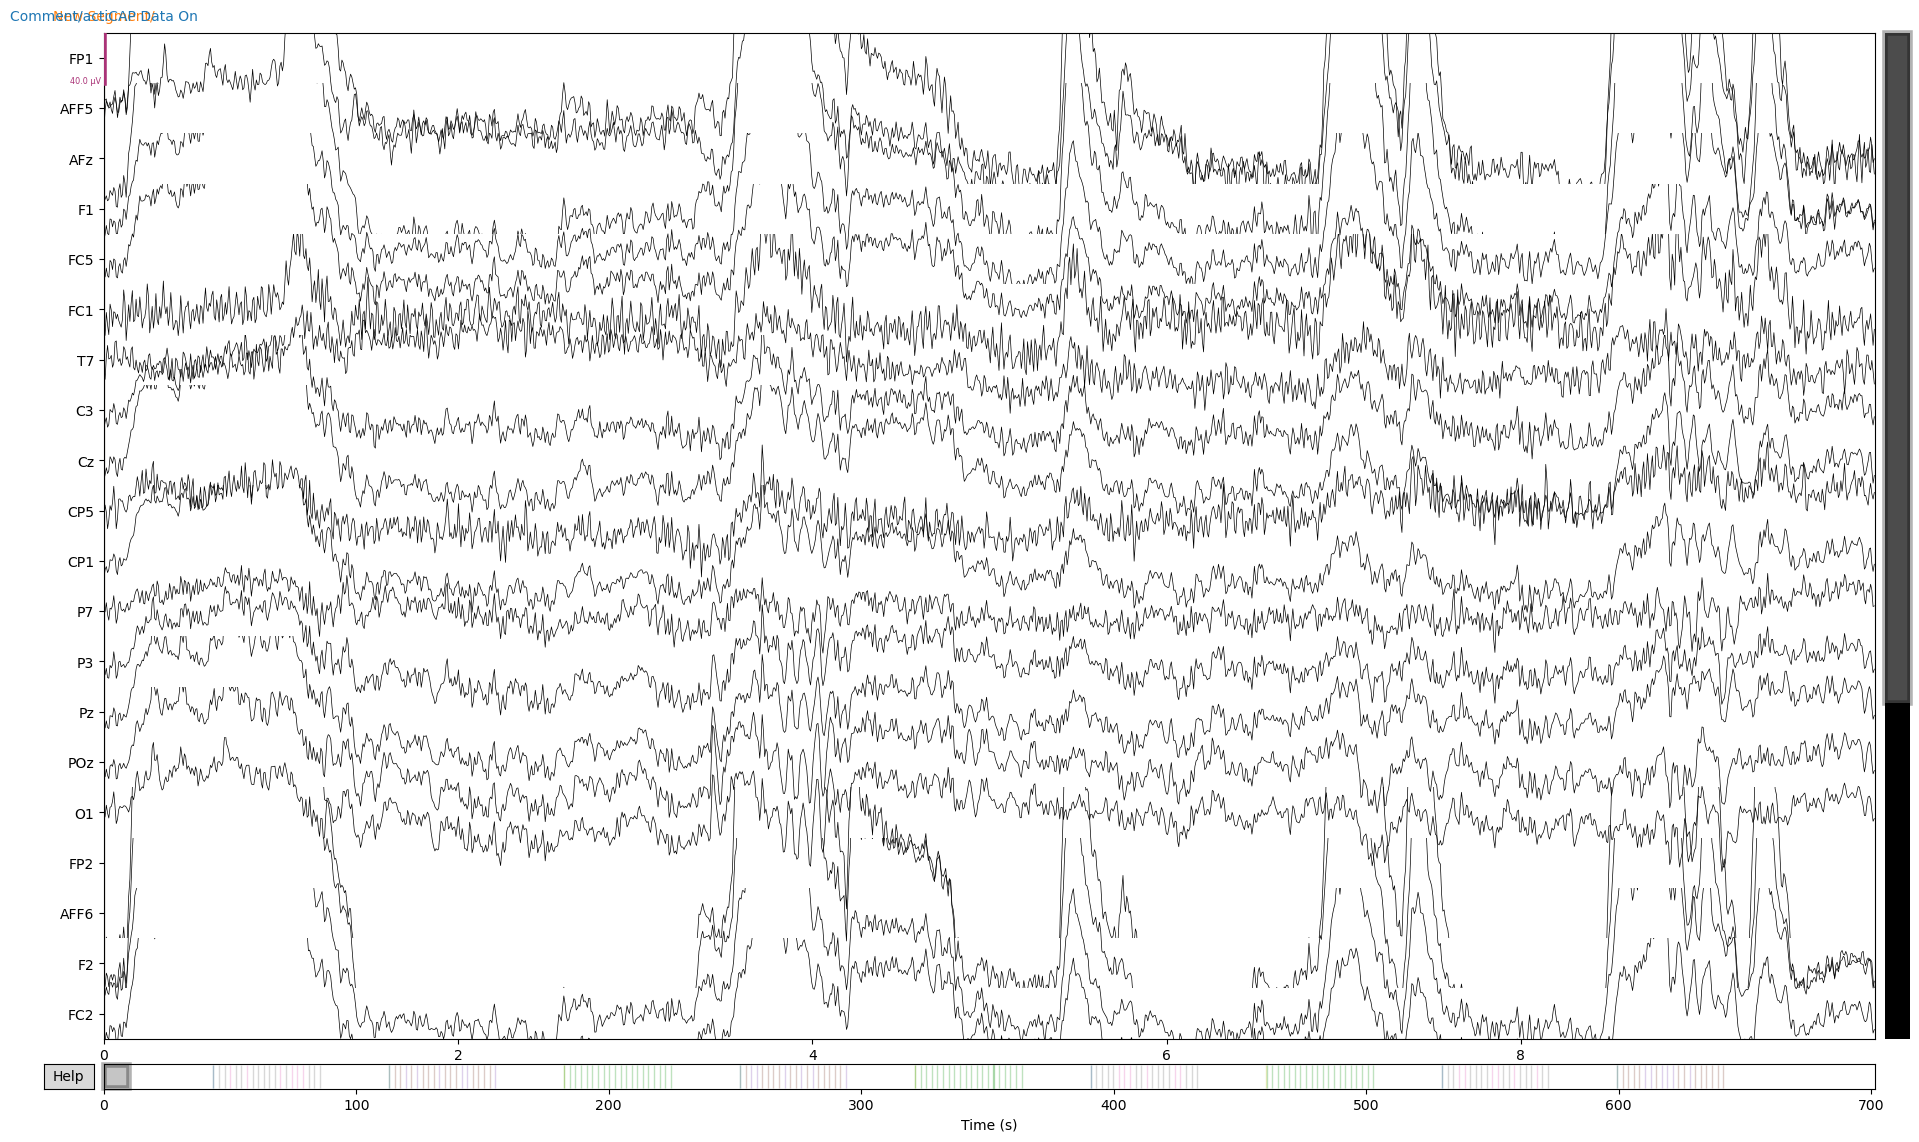

In [15]:
raw_filtered.plot()

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)



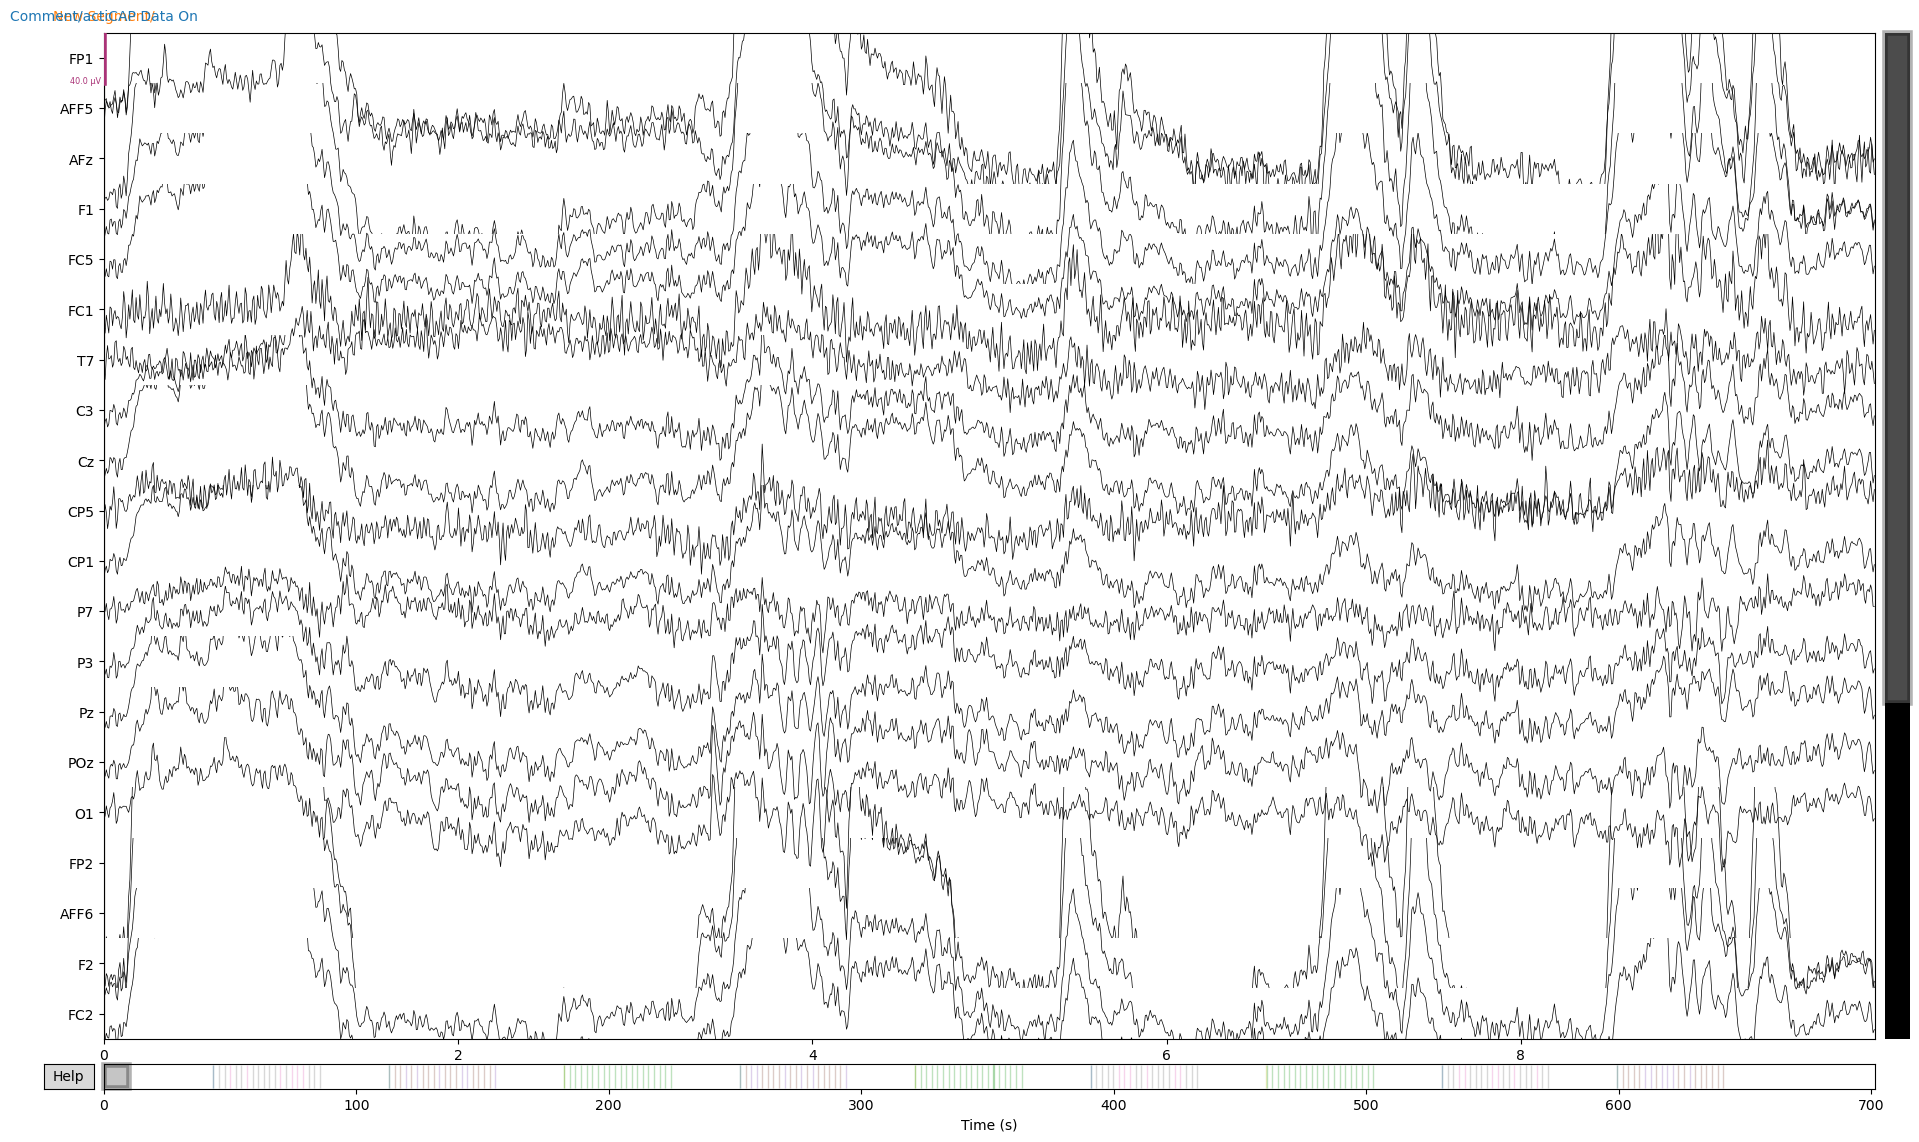

In [16]:
raw_notch_filtered = raw_filtered.notch_filter(50, filter_length='auto', phase='zero')
raw_notch_filtered.plot()          
            

In [17]:
raw_re_referenced = mne.set_eeg_reference(raw_notch_filtered,ref_channels='average',copy=True, projection=False)
finData, times = raw_re_referenced[:]

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


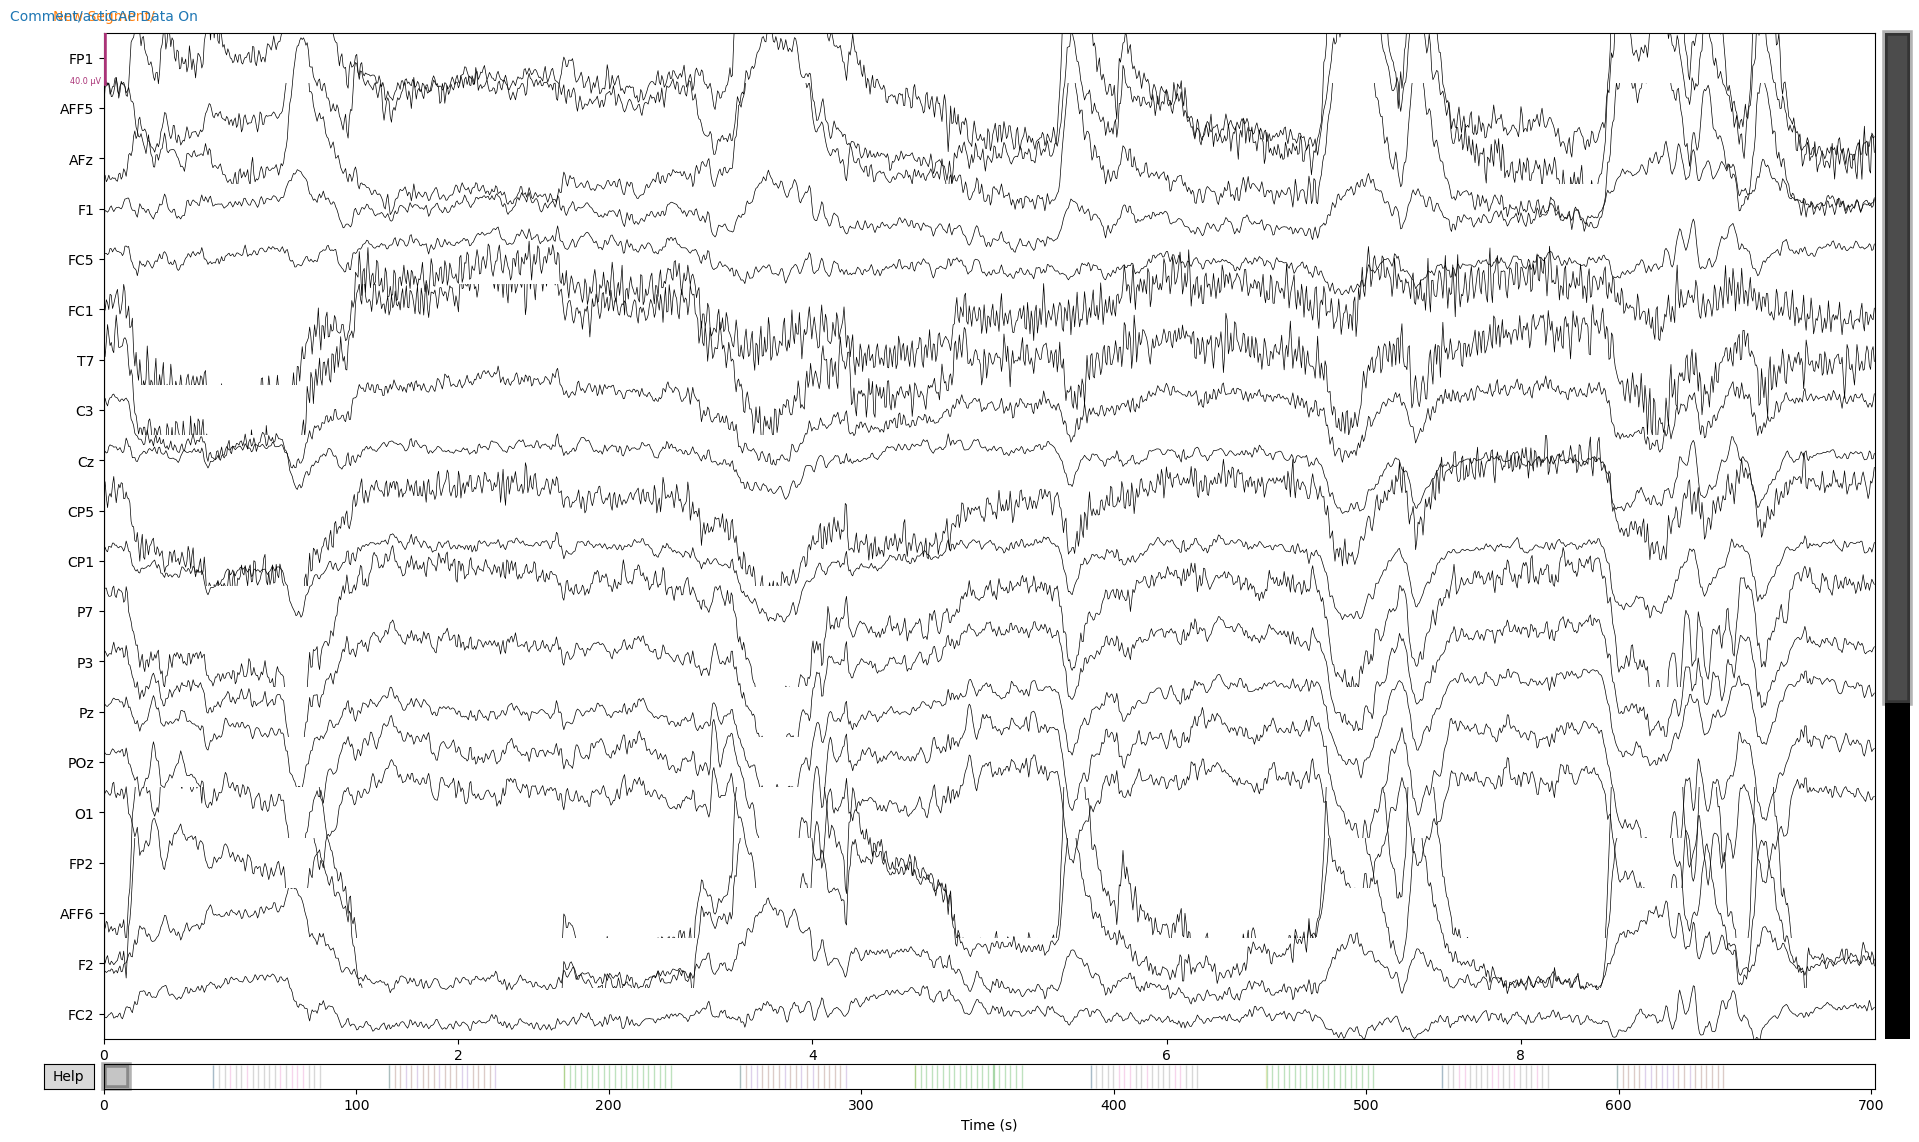

In [18]:
finData.plot()

In [19]:
fig, ax = plt.subplots(2)
raw.plot_psd(ax=ax[0], show = False, fmax = 60)
finData.plot_psd(ax=ax[1], show = False, fmax=60)
ax[0].set_title("PSD before filtering")
ax[1].set_title("PSD after filtering")
ax[1].set_xlabel('Frequency(Hz)')
fig.set_tight_layout(True)
plt.show()

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


In [20]:
n_components = 10 #number of components you want to fit # can be either integer which typically implies number of channels - 1 (if applied average reference)
                  #if floating point number (0-1) fraction of total explained variance
method = 'fastica'
max_iter = 100
fit_params = dict(fastica_it = 5)
random_state = 42
ica = mne.preprocessing.ICA(n_components = n_components,
                        method = method,
                        max_iter=max_iter,
                        random_state= random_state
                        )
ica.fit(finData)

Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 8.2s.


<ICA | raw data decomposition, fit (fastica): 701440 samples, 10 components, channels used: "eeg">

In [21]:
finData.load_data()
ica.plot_sources(finData, show_scrollbars=False)
ica.plot_components(sphere=1)

Creating RawArray with float64 data, n_channels=12, n_times=701440
    Range : 0 ... 701439 =      0.000 ...   701.439 secs
Ready.


[<MNEFigure size 975x496 with 10 Axes>]

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 28 PCA components


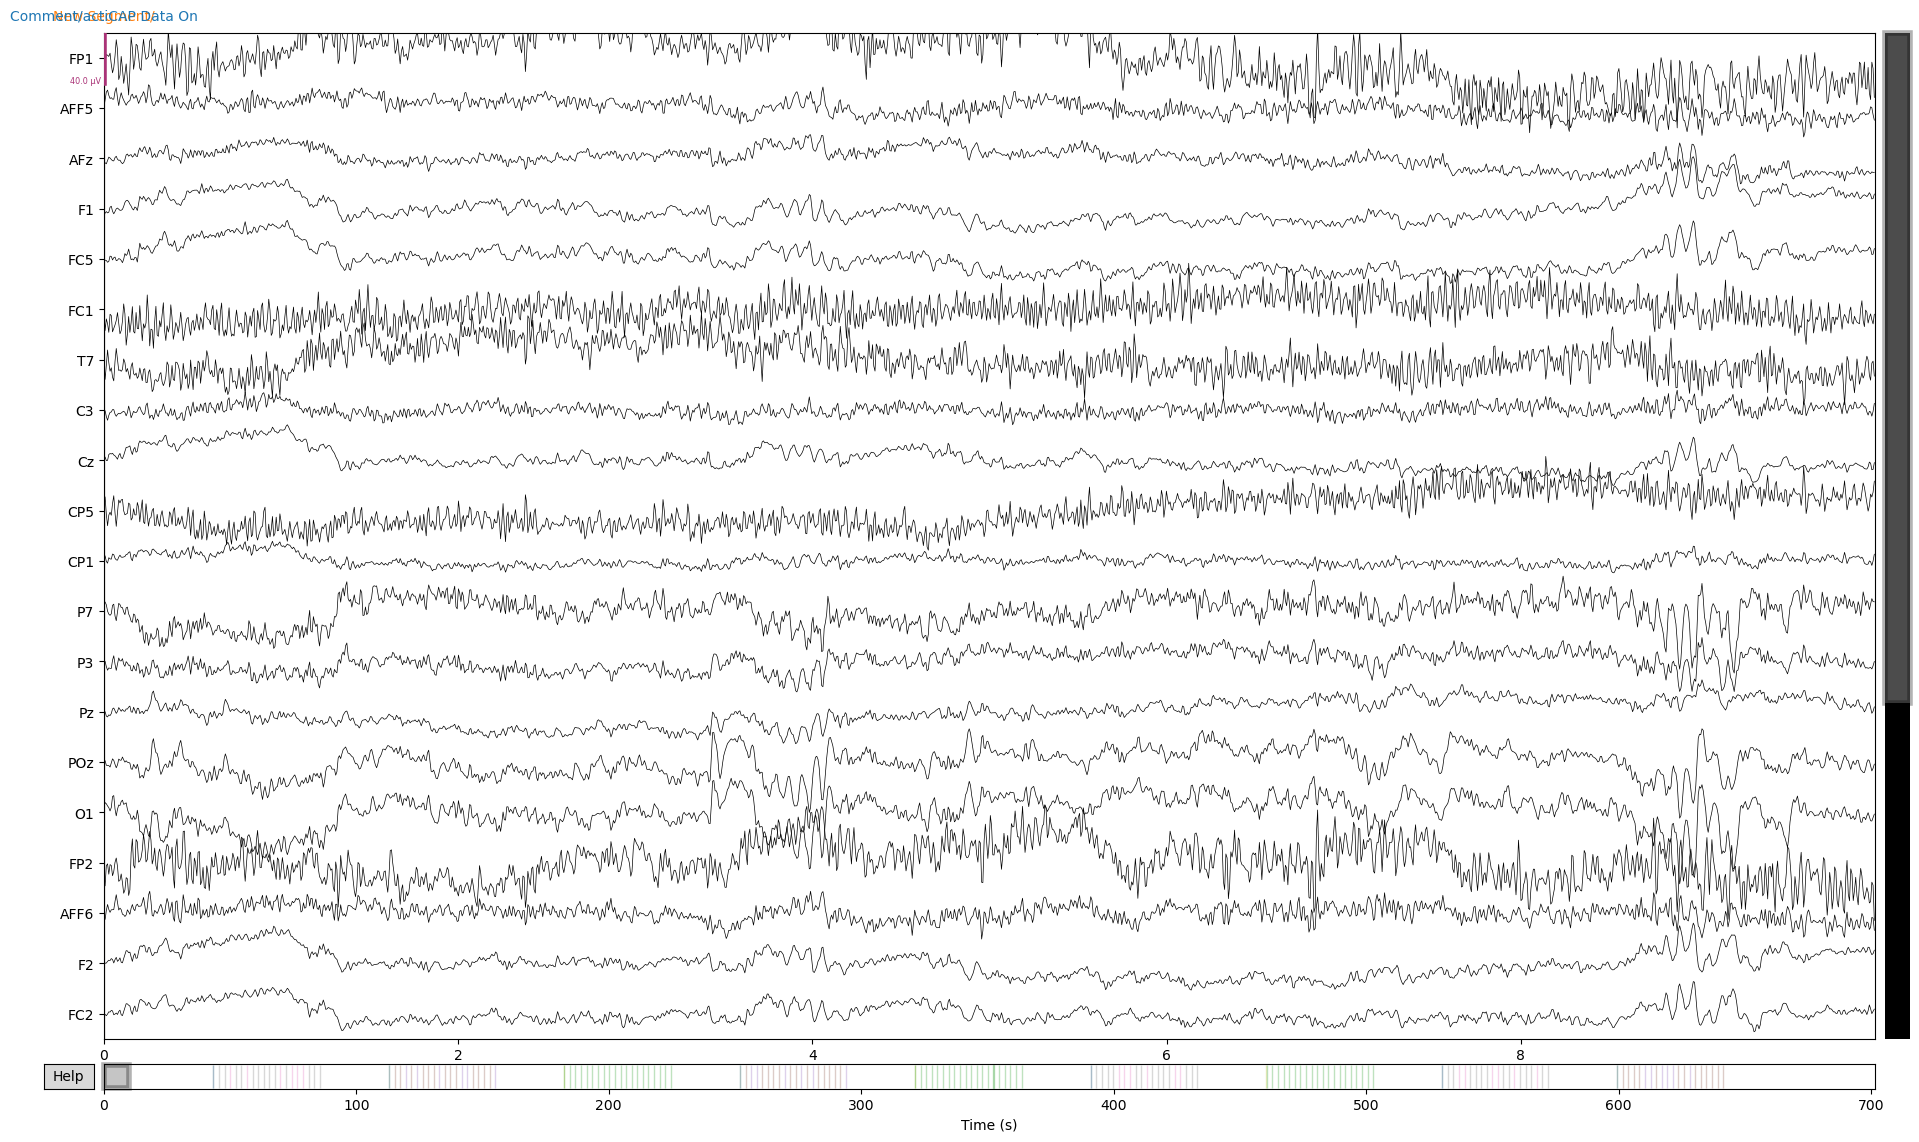

In [22]:
#Manual Eye Artifact Removal
ica.exclude = [0, 3]  
reconst_raw = finData.copy()
ica.apply(reconst_raw)

finData.plot(title = "finData")
reconst_raw.plot(title = "Manual")

Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1

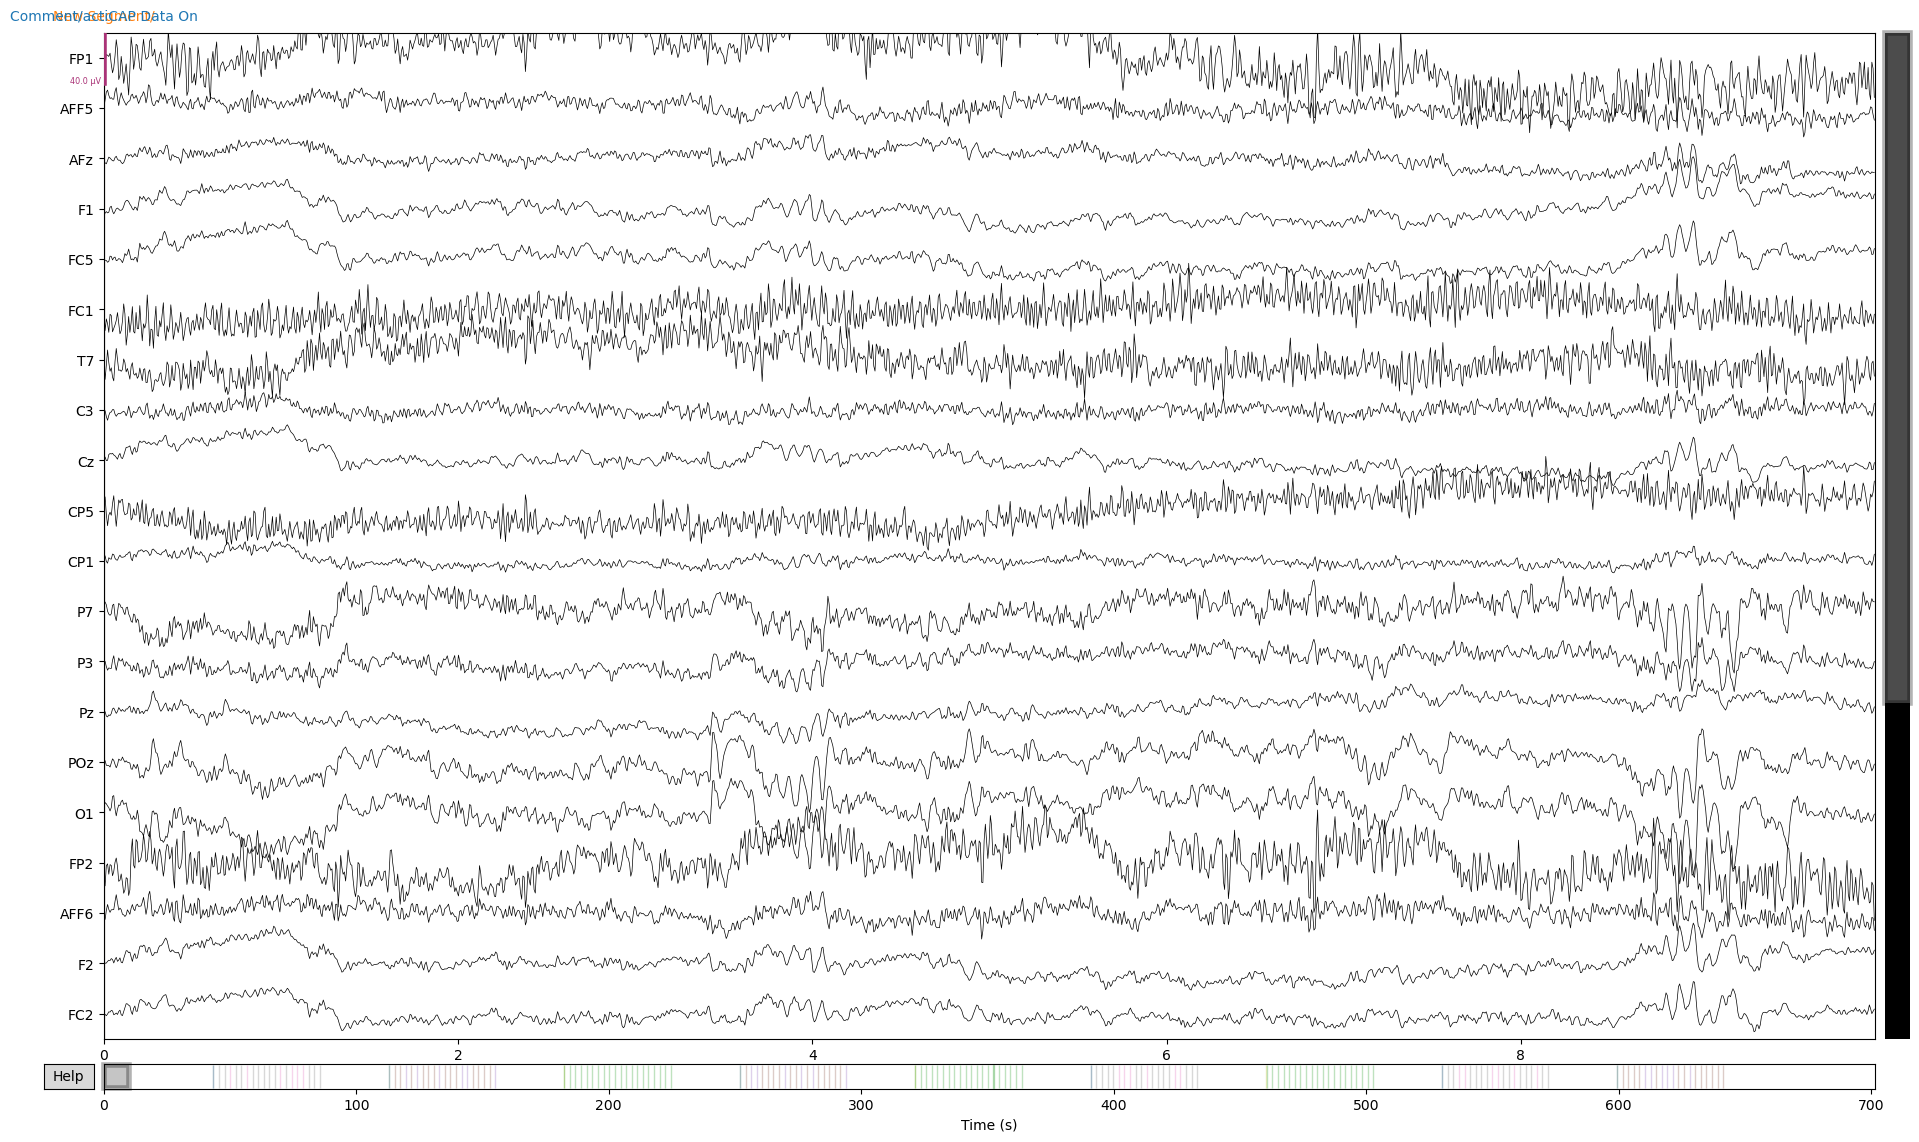

In [24]:
#Automatic (Threshold Based) Eye Artifact Removal
ica.exclude = []
reconst_raw = finData.copy()
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(finData, threshold = 2.5)
ica.exclude = eog_indices
ica.apply(reconst_raw)

#print(eog_indices)

reconst_raw.plot(title="Automatic")


# # barplot of ICA component "EOG match" scores
# ica.plot_scores(eog_scores)

# # plot diagnostics
# ica.plot_properties(finData, picks=eog_indices)

# # plot ICs applied to raw data, with EOG matches highlighted
# ica.plot_sources(finData, show_scrollbars=False)

# # plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
# ica.plot_sources(eog_evoked)


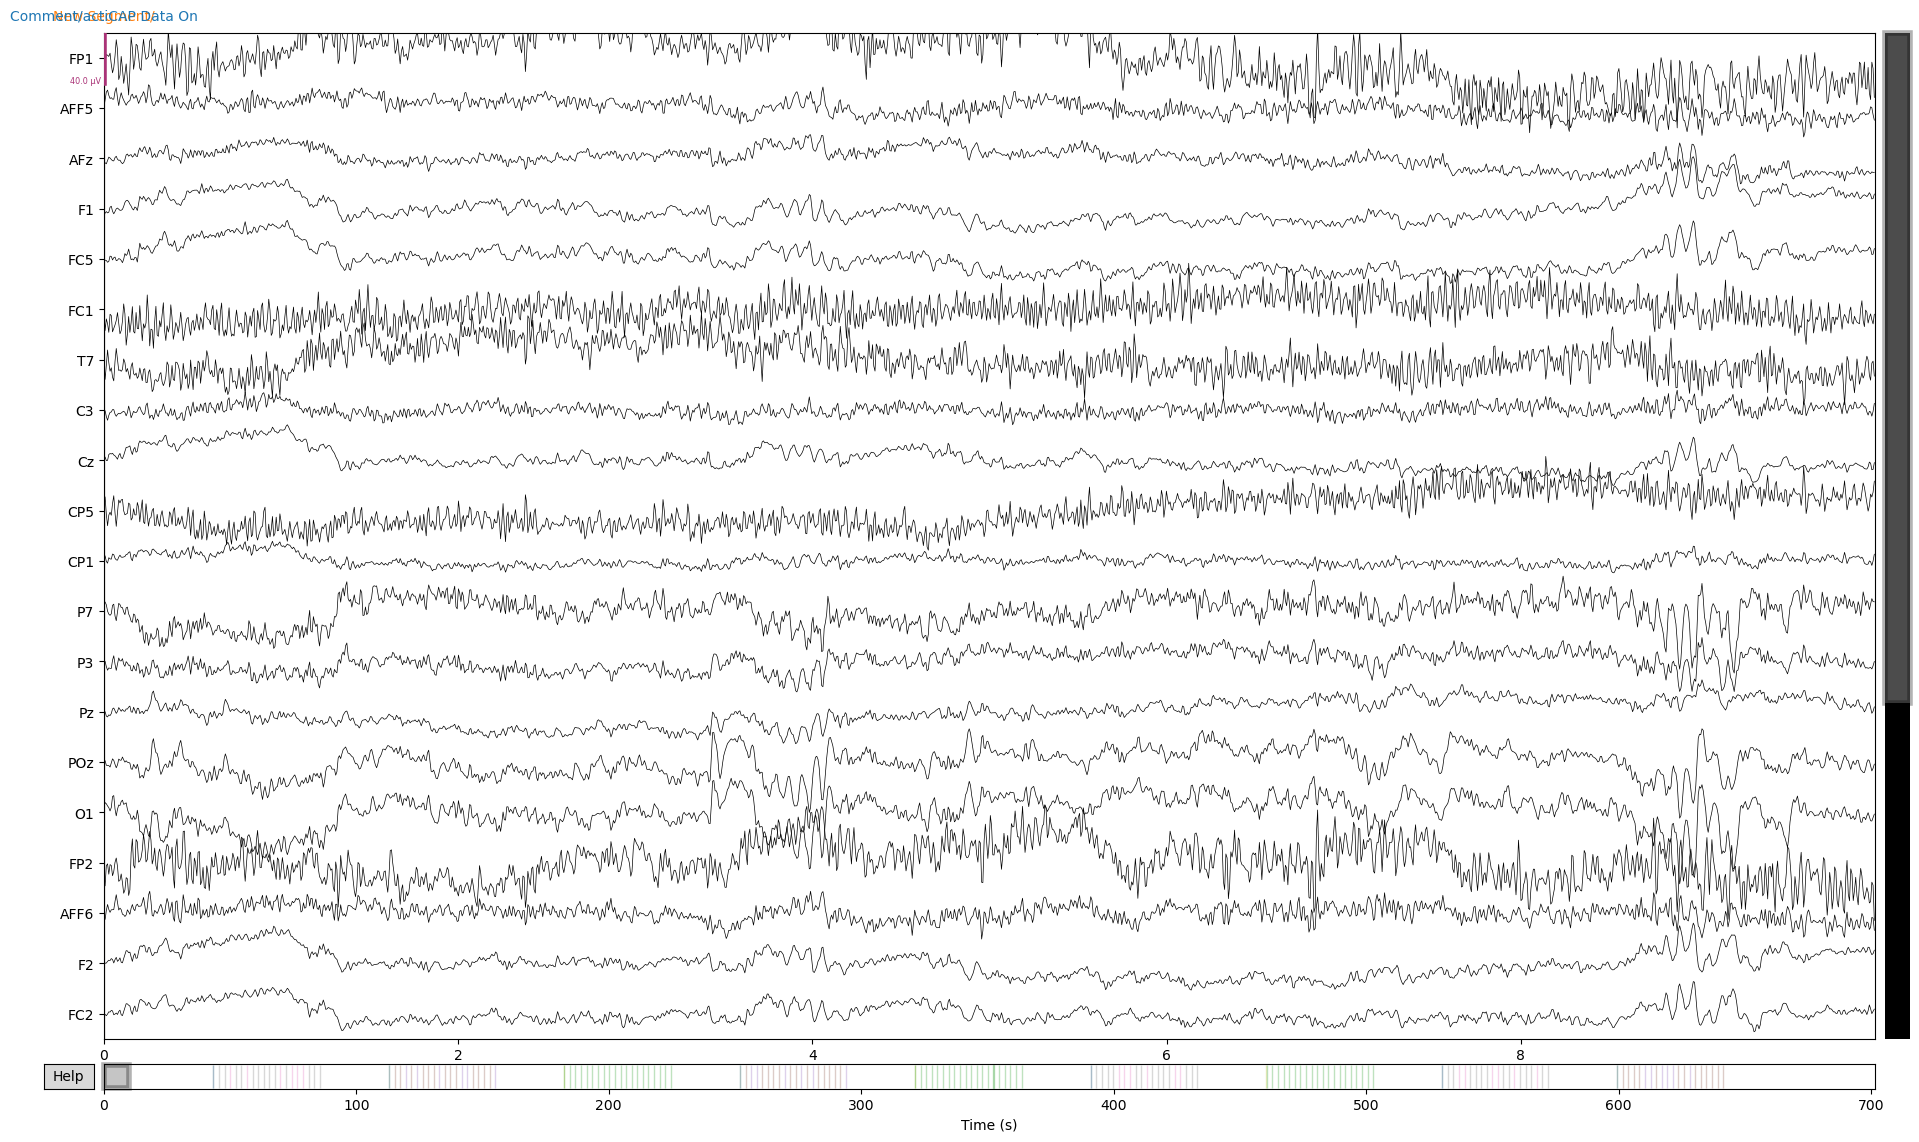

In [25]:
reconst_raw.plot()

In [26]:
events_ids = {
 'Stimulus/S 16': 16,
 'Stimulus/S 48': 48,
 'Stimulus/S 64': 64,
 'Stimulus/S 80': 80,
 'Stimulus/S 96': 96}
events_ids

{'Stimulus/S 16': 16,
 'Stimulus/S 48': 48,
 'Stimulus/S 64': 64,
 'Stimulus/S 80': 80,
 'Stimulus/S 96': 96}

In [27]:
event,event_ids = mne.events_from_annotations(reconst_raw, events_ids)

Used Annotations descriptions: ['Stimulus/S 16', 'Stimulus/S 48', 'Stimulus/S 64', 'Stimulus/S 80', 'Stimulus/S 96']


In [36]:
event_ids

{'Stimulus/S 16': 16,
 'Stimulus/S 48': 48,
 'Stimulus/S 64': 64,
 'Stimulus/S 80': 80,
 'Stimulus/S 96': 96}

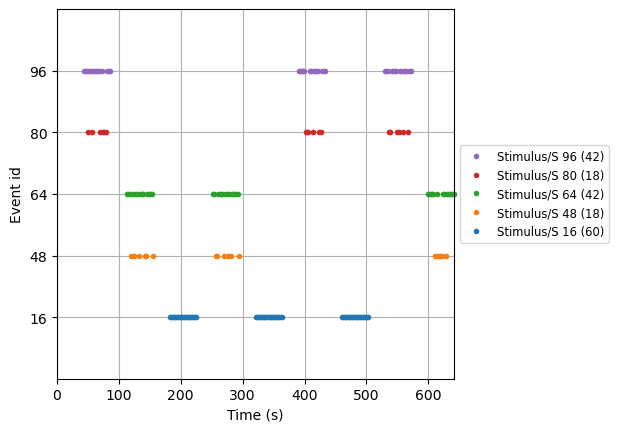

In [32]:
mne.viz.plot_events(event,event_id = events_ids, sfreq=raw.info['sfreq'])

In [35]:
tmin=-0.3 # when does the epoch start relative to the event onset # 300ms before the start of the event
tmax=1.7  # when does the event end after the even onset # 500 ms from the start of the event

#Is a tuple containing the start of the baseline and end of the baseline
baseline= (None, 0) #None mean begnining of the event and 0 is the start of the event 

epochs = mne.Epochs(reconst_raw, 
                    events=event,
                    event_id=event_ids,
                    tmin=tmin,tmax=tmax, 
                    baseline=baseline,
                    preload=True,event_repeated = 'drop')

Not setting metadata
Not setting metadata
180 matching events found
Setting baseline interval to [-0.3, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 180 events and 2001 original time points ...
0 bad epochs dropped


In [ ]:
epochs.plot(events=event, event_id = event_ids)

In [ ]:
e3=event[:,-1]
e4 = np.repeat(e3,2001, axis=0)
e5 = np.reshape(e4,(180,2001))

In [ ]:
import numpy as np
j=0
dat = []
for i in epochs:
    dat.append(np.concatenate((i,e5[j].reshape(1,-1)),axis=0))
    j+=1
dat = np.array(dat)

In [ ]:
dat.shape

C:\Users\Fujitsu\anaconda3\envs\rtmse\lib\site-packages\ipykernel\eventloops.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  app.exec_()


Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
